In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from naca4digit_airfoil import Naca4DigitAirfoil
from navier_stokes import NavierStokesPDEs
import utils
import pandas as pd
from scipy.interpolate import griddata

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
cfd_df = pd.read_csv('NACA2412.txt', delimiter=',')

In [3]:
x_min_init = -0.25
x_max_init = 0.75
y_min_init = -0.25
y_max_init = 0.25

x_min = -0.05
x_max = 0.15
y_min = -0.05
y_max = 0.05

In [4]:
def set_domain_lims(ax):
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

def set_zoomed_domain_lims(ax):
    ax.set_xlim(x_min/2, x_max/2)
    ax.set_ylim(y_min/2, y_max/2)

def set_labels(ax):
    ax.set_xlabel('$x \; (m)$')
    ax.set_ylabel('$y \; (m)$')

plt.rcParams['axes.labelsize'] = 20   # Increase the size of labels
plt.rcParams['axes.titlesize'] = 20   # Increase the size of titles
plt.rcParams['xtick.labelsize'] = 15  # Increase the size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 15  # Increase the size of y-axis tick labels

In [5]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')
dde.config.set_parallel_scaling('strong')

Set the default float type to float64


In [6]:
rho  = 1.225
# mu   = 1.789e-5
# mu   = 0.0002
mu   = 0.44725e-7
# u_in  = 15
u_inlet  = 0.75
L = 0.05

Re = rho * u_inlet * L / mu

In [7]:
rho, mu, u_inlet, L, Re

(1.225, 4.4725e-08, 0.75, 0.05, 1027110.1173840136)

In [8]:
airfoil = Naca4DigitAirfoil(c=L, M=2, P=4, T=12, a=0, offset_x=0, offset_y=0)

In [9]:
# Geometry defintion
farfield = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

inner_rec  = dde.geometry.Rectangle([-0.01, -0.01], [0.01, 0.01])
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)

mid_rec  = dde.geometry.Rectangle([-0.03, -0.02], [0.075, 0.02])
mid_dom  = dde.geometry.CSGDifference(mid_rec, inner_rec)
mid_dom  = dde.geometry.CSGDifference(mid_dom, airfoil_geom)

outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, mid_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)

In [10]:
Nf1 = 2**14 # = 16384
Nf2 = 2**14 # = 16384
Nf3 = 2**16 # = 65536
Nb  = 2**11 # = 2048
Ns  = 250

random = "Sobol"
inner_points = inner_dom.random_points(Nf1, random=random)
mid_points = mid_dom.random_points(Nf2, random=random)
outer_points = outer_dom.random_points(Nf3, random=random)

farfield_points = farfield.random_boundary_points(Nb, random=random)
airfoil_points  = airfoil.get_boundary_points(Ns)

static_points = np.append(inner_points, mid_points, axis = 0)
static_points = np.append(static_points, airfoil_points, axis = 0)

/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+16385=16385. 
  warnings.warn(
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+16385=16385. 
  warnings.warn(
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+16385=16385. 
  warnings.warn(
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+16385=16385. 
  warnings.warn(


/var/folders/t3/9mj_24gd1w97bqts_sw0yhbw0000gn/T/ipykernel_18657/200457580.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legend_handle in legend.legendHandles:


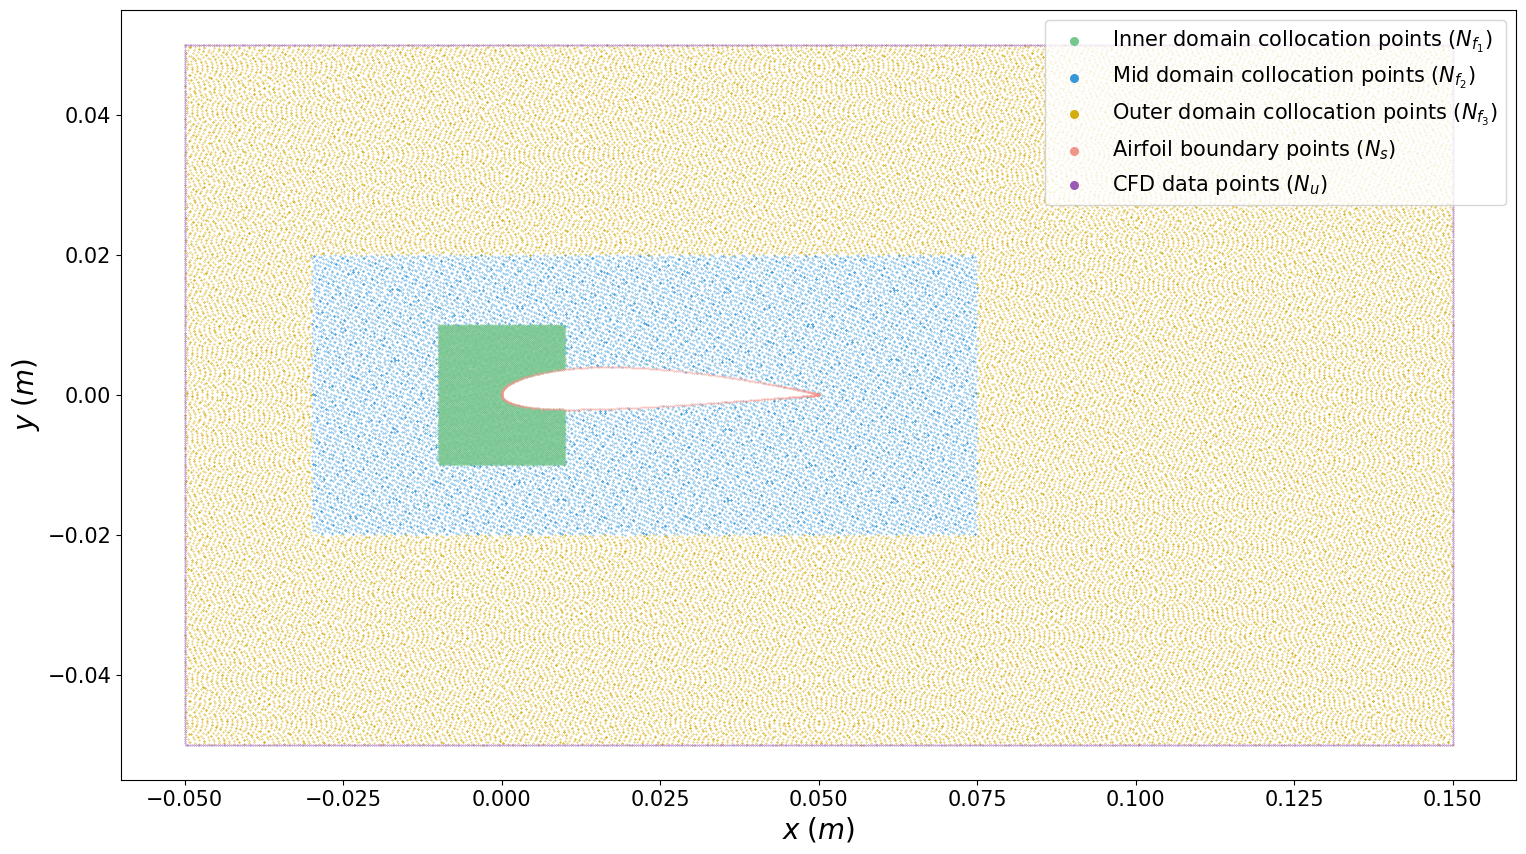

In [11]:
fig, ax = plt.subplots(figsize=(18, 10))
set_labels(ax)
# ax.set_title('Sampled Training Points')
ax.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.1, c = '#76c68f', label = 'Inner domain collocation points ($N_{f_1}$)')
ax.scatter(mid_points[:, 0], mid_points[:, 1], s = 0.1, c = '#3498db', label = 'Mid domain collocation points ($N_{f_2}$)')
ax.scatter(outer_points[:, 0], outer_points[:, 1], s = 0.1, c = '#d4ac0d', label = 'Outer domain collocation points ($N_{f_3})$')
ax.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.1, c = '#f1948a', label = 'Airfoil boundary points ($N_s$)')
ax.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.1, c='#9b59b6', label = 'CFD data points ($N_u$)')
# ax.fill(airfoil_points[:, 0], airfoil_points[:, 1])
ax.grid(False)
legend = ax.legend(loc = 'upper right', fontsize = 15)
for legend_handle in legend.legendHandles:
    legend_handle._sizes = [30]  # Adjusting the size of the markers in the legend
plt.savefig('hybrid_sampling1.png', dpi=300)
plt.show()

In [12]:
x_data = farfield_points[:, 0]
y_data = farfield_points[:, 1]

grid_points = cfd_df[['x', 'y']].values / 20
u_values = cfd_df['u'].values / 20
v_values = cfd_df['v'].values / 20
# p_values = cfd_df['p'].values

u_interp = griddata(grid_points, u_values, (x_data, y_data), method='linear')
v_interp = griddata(grid_points, v_values, (x_data, y_data), method='linear')
# p_interp = griddata(grid_points, p_values, (x_data, y_data), method='linear')

# uvp_data = np.vstack((u_interp, v_interp, p_interp)).T
uv_data = np.vstack((u_interp, v_interp)).T
# u_data = np.array([uvp_data[i][0] for i in range(len(uvp_data))])
# v_data = np.array([uvp_data[i][1] for i in range(len(uvp_data))])
# p_data = np.array([uvp_data[i][2] for i in range(len(uvp_data))])
u_data = np.array([uv_data[i][0] for i in range(len(uv_data))])
v_data = np.array([uv_data[i][1] for i in range(len(uv_data))])

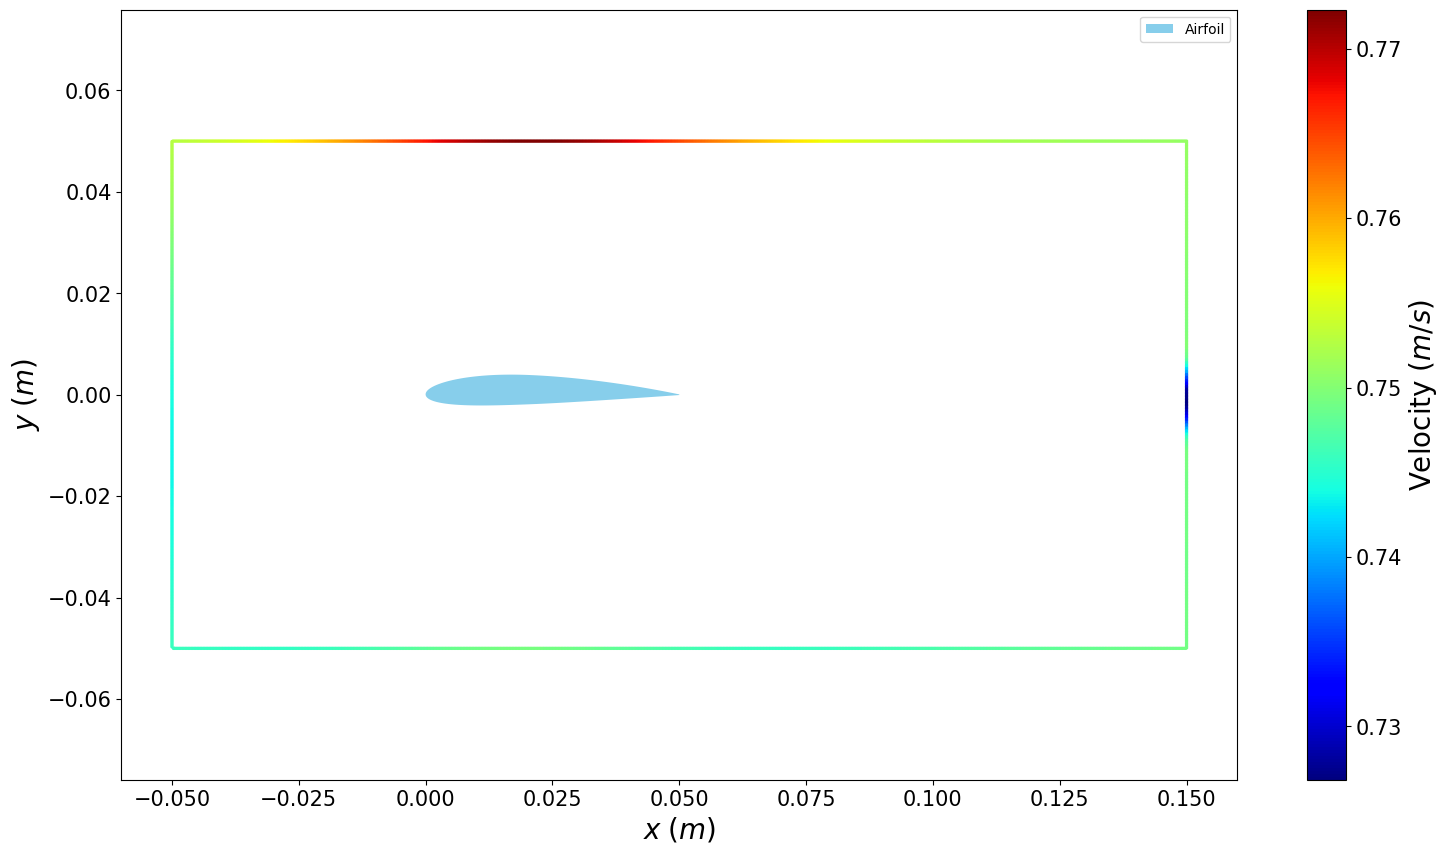

In [13]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.axis('equal')
scatter = plt.scatter(x_data, y_data, c=u_data, s=2, cmap='jet')
set_labels(ax)
plt.colorbar(scatter, ax=ax, label='Velocity $(m/s)$')
# plt.title('CFD Solver Boundary Data, Velocity Field - X Component')
airfoil.plot(ax)
plt.xlim([x_min - 0.01, x_max + 0.01])
plt.ylim([y_min - 0.01, y_max + 0.01])
ax.grid(False)
plt.savefig('u_boundary_cfd.png', dpi=300)
plt.show()

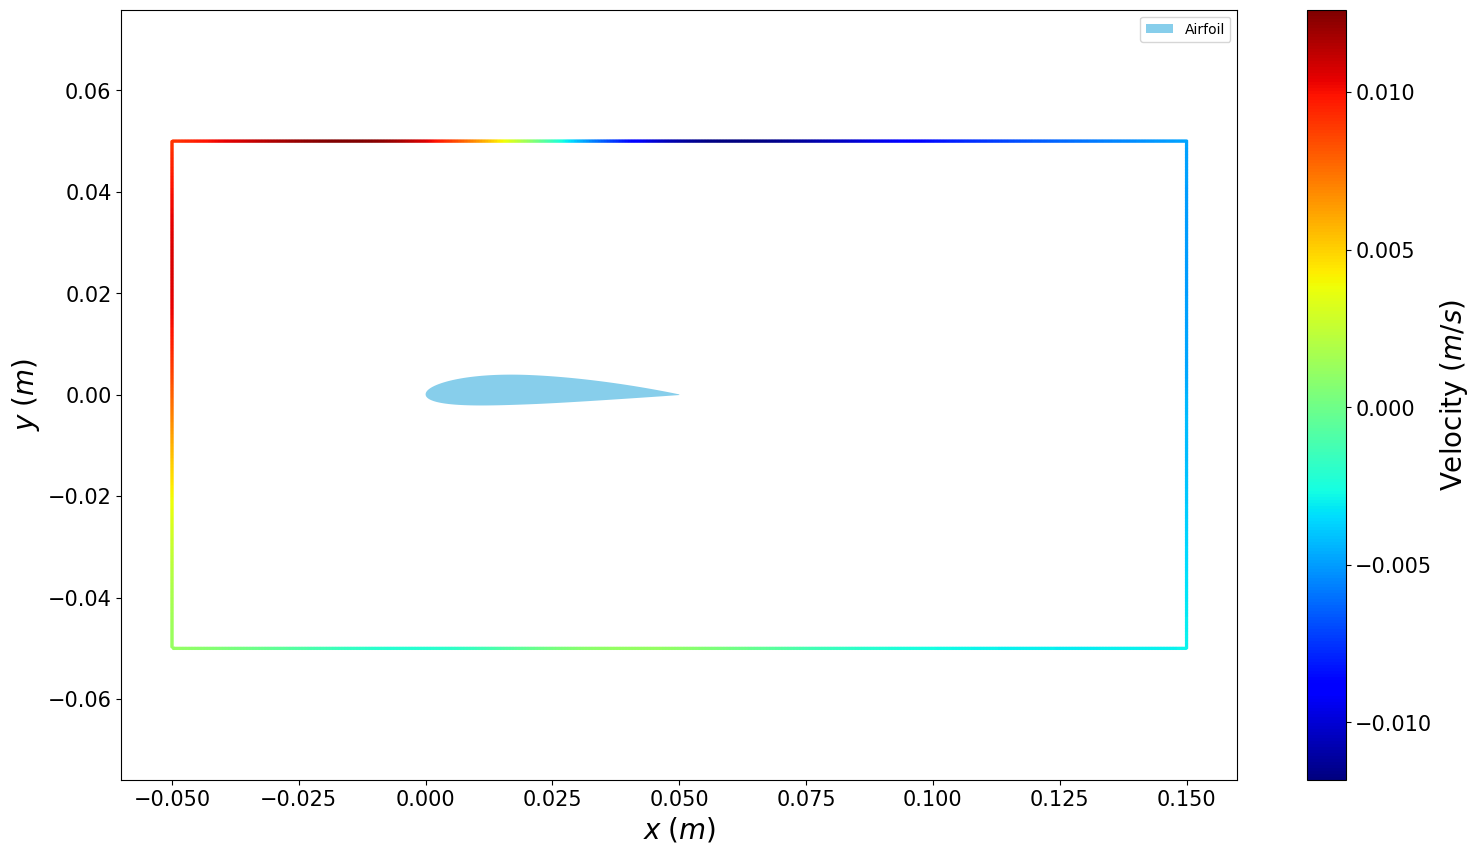

In [14]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.axis('equal')
scatter = plt.scatter(x_data, y_data, c=v_data, s=2, cmap='jet')
set_labels(ax)
plt.colorbar(scatter, ax=ax, label='Velocity $(m/s)$')
# plt.title('CFD Solver Boundary Data, Velocity Field - Y Component')
airfoil.plot(ax)
plt.xlim([x_min - 0.01, x_max + 0.01])
plt.ylim([y_min - 0.01, y_max + 0.01])
ax.grid(False)
plt.savefig('v_boundary_cfd.png', dpi=300)
plt.show()

In [15]:
# fig, ax = plt.subplots(figsize=(18, 10))
# plt.axis('equal')
# scatter = plt.scatter(x_data, y_data, c=p_data, s=2, cmap='jet')
# set_labels(ax)
# plt.colorbar(scatter, ax=ax, label='Velocity')
# plt.title('CFD Solver Boundary Data, Pressure Field')
# airfoil.plot(ax)
# plt.xlim([x_min - 0.01, x_max + 0.01])
# plt.ylim([y_min - 0.01, y_max + 0.01])
# ax.grid(False)
# plt.savefig('p_boundary_cfd.png', dpi=300)
# plt.show()

In [16]:
navier_stokes_pdes = NavierStokesPDEs(rho=rho, mu=mu,
                                      xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max,
                                      airfoil_geom=airfoil_geom, geom=geom,
                                      x_data=x_data, y_data=y_data, u_data=u_data, v_data=v_data)

pdes_fun = navier_stokes_pdes.get_pdes
bcs = navier_stokes_pdes.get_bcs_with_data()

In [17]:
# Problem setup
data = dde.data.PDE(geom, pdes_fun, bcs, num_domain = Nf3, num_boundary = 0, num_test = 1000, anchors = static_points, train_distribution = "Hammersley")

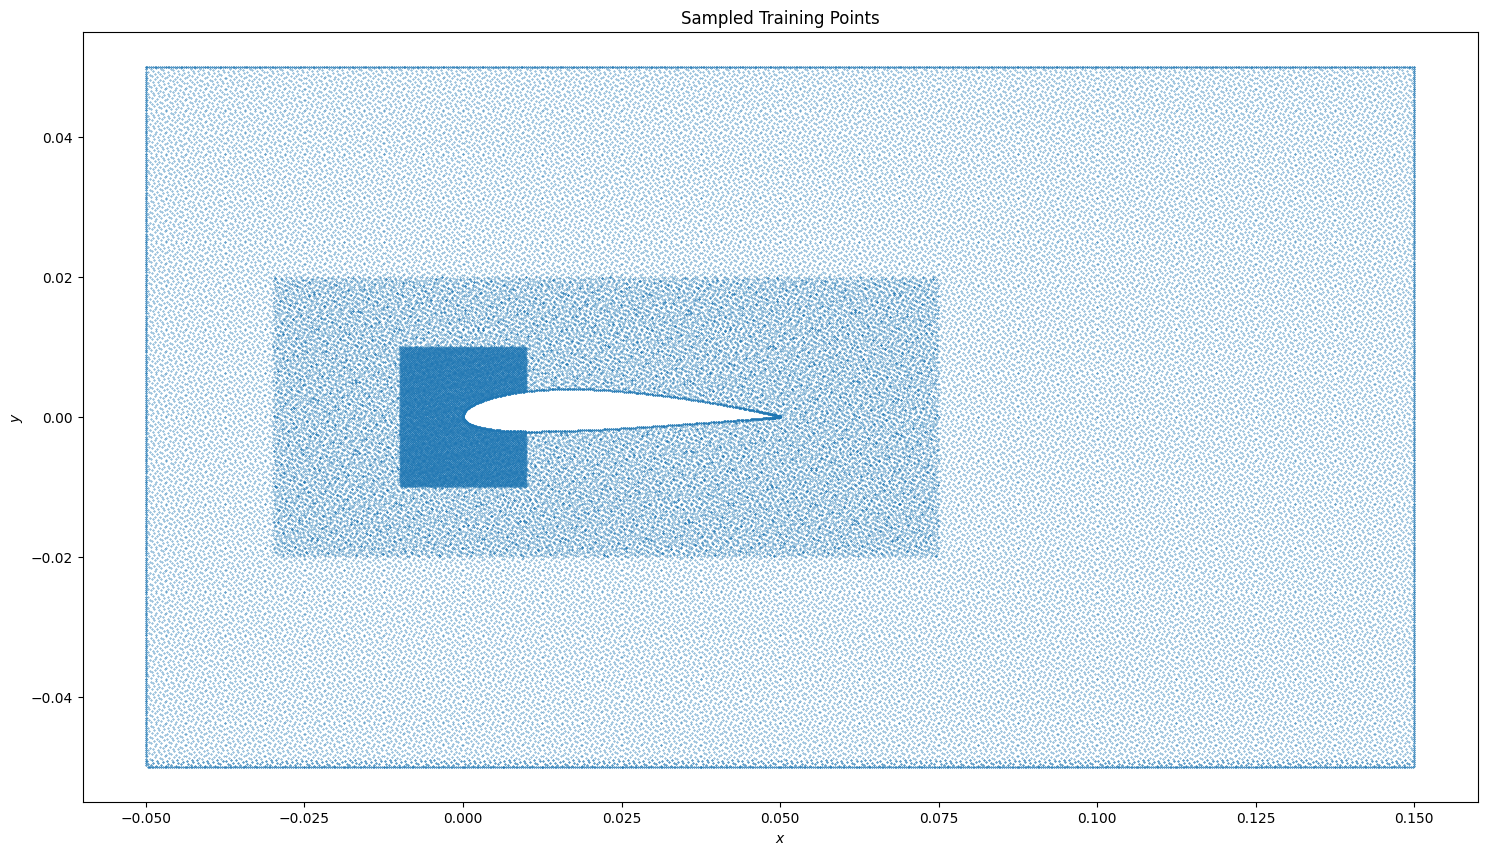

In [19]:
fig, ax = plt.subplots(figsize=(18, 10))
set_labels(ax)
# ax.set_title('Sampled Training Points')
ax.scatter(data.train_x[:,0], data.train_x[:,1], s = 0.1)
ax.grid(False)
plt.savefig('hybrid_sampling2.png', dpi=300)
plt.show()

In [20]:
# Neural network definition
layer_size  = [2] + [50] * 10 + [5]
activation  = 'tanh'
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)

In [28]:
name_generator = utils.NameGenerator()
model_name = name_generator.generate_name()
model_name

'JetStreamAnalyticVoyager510'

In [29]:
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights=[1, 1, 1, 1, 1, 1, 4, 4, 4, 4])

Compiling model...
'compile' took 0.005937 s



In [30]:
resampler = dde.callbacks.PDEPointResampler(period = 100, pde_points=True, bc_points=False)

In [36]:
try:
  losshistory, train_state = model.train(epochs = 20000, display_every = 100, callbacks=[resampler], model_save_path = './' + model_name + '/')
  dde.saveplot(losshistory, train_state, issave = True, isplot = True)

except KeyboardInterrupt:
  print(f"Training stopped by user.")
  print("=======================================================")

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
20000     [4.63e-03, 1.87e-03, 8.76e-05, 7.94e-05, 1.14e-04, 4.33e-06, 1.44e-03, 1.43e-03, 9.79e-04, 3.11e-05]    [4.20e-03, 1.74e-03, 1.04e-04, 8.38e-05, 1.52e-04, 4.69e-06, 1.44e-03, 1.43e-03, 9.79e-04, 3.11e-05]    []  
20100     [7.60e-04, 3.00e-04, 9.19e-05, 8.03e-05, 1.13e-04, 5.78e-06, 1.20e-03, 1.36e-03, 7.95e-04, 3.25e-05]    [4.52e-04, 3.03e-04, 1.03e-04, 1.01e-04, 1.56e-04, 6.11e-06, 1.20e-03, 1.36e-03, 7.95e-04, 3.25e-05]    []  
20200     [1.19e-02, 2.44e-03, 1.07e-04, 8.04e-05, 1.19e-04, 7.34e-06, 1.80e-03, 1.30e-03, 6.58e-04, 2.58e-05]    [9.22e-03, 1.35e-03, 1.07e-04, 9.48e-05, 1.58e-04, 7.40e-06, 1.80e-03, 1.30e-03, 6.58e-04, 2.58e-05]    []  
20300     [5.61e-04, 2.45e-04, 9.18e-05, 7.85e-05, 1.19e-04, 2.16e-06, 5.24e-04, 1

In [ ]:
# model_name = 'AtmosElegantGalaxy375'
# model.restore('./out/AtmosElegantGalaxy375/-20000.ckpt.index')

In [32]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.001
dy = 0.001
x = np.arange(x_min, x_max + dy, dx)
y = np.arange(y_min, y_max + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [33]:
# Model predictions generation
u = model.predict(X, operator = navier_stokes_pdes.getU)
v = model.predict(X, operator = navier_stokes_pdes.getV)
p = model.predict(X, operator = navier_stokes_pdes.getP)

In [34]:
# save results to csv
df = pd.DataFrame(data = {'x': xs, 'y': ys, 'u': u.reshape(-1), 'v': v.reshape(-1), 'p': p.reshape(-1)})
df.to_csv('results_hybrid.csv', index=False)

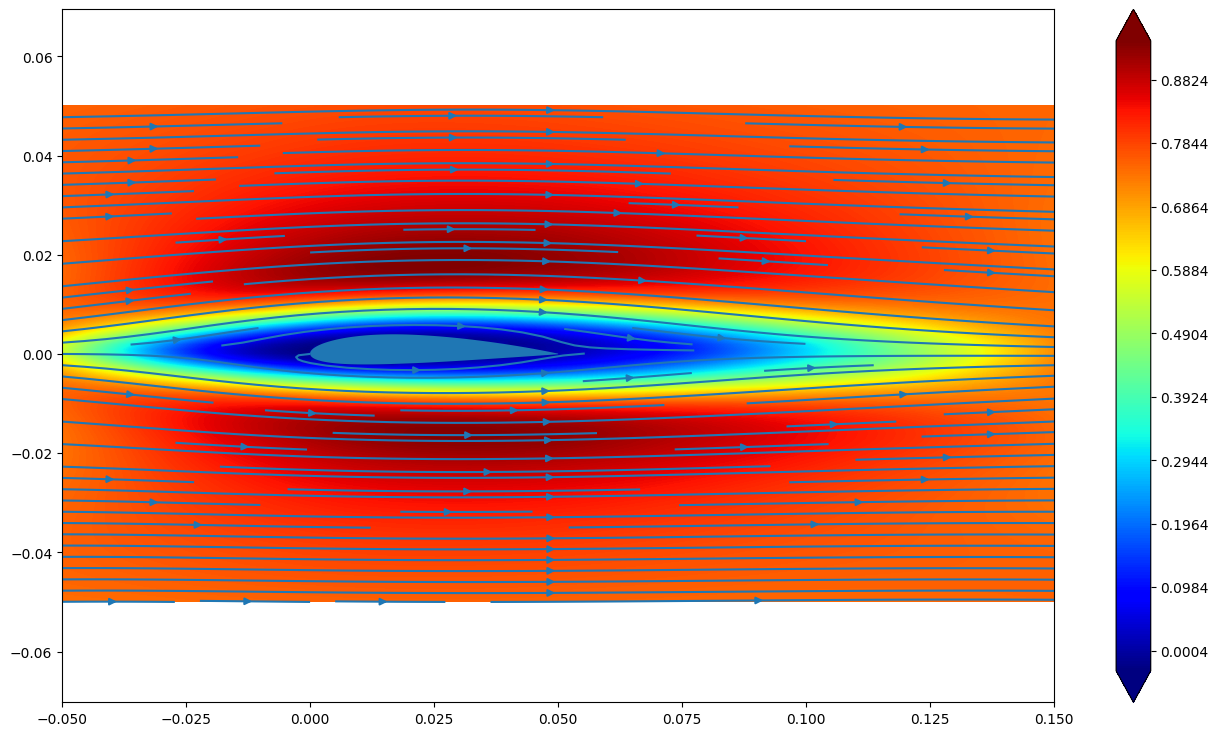

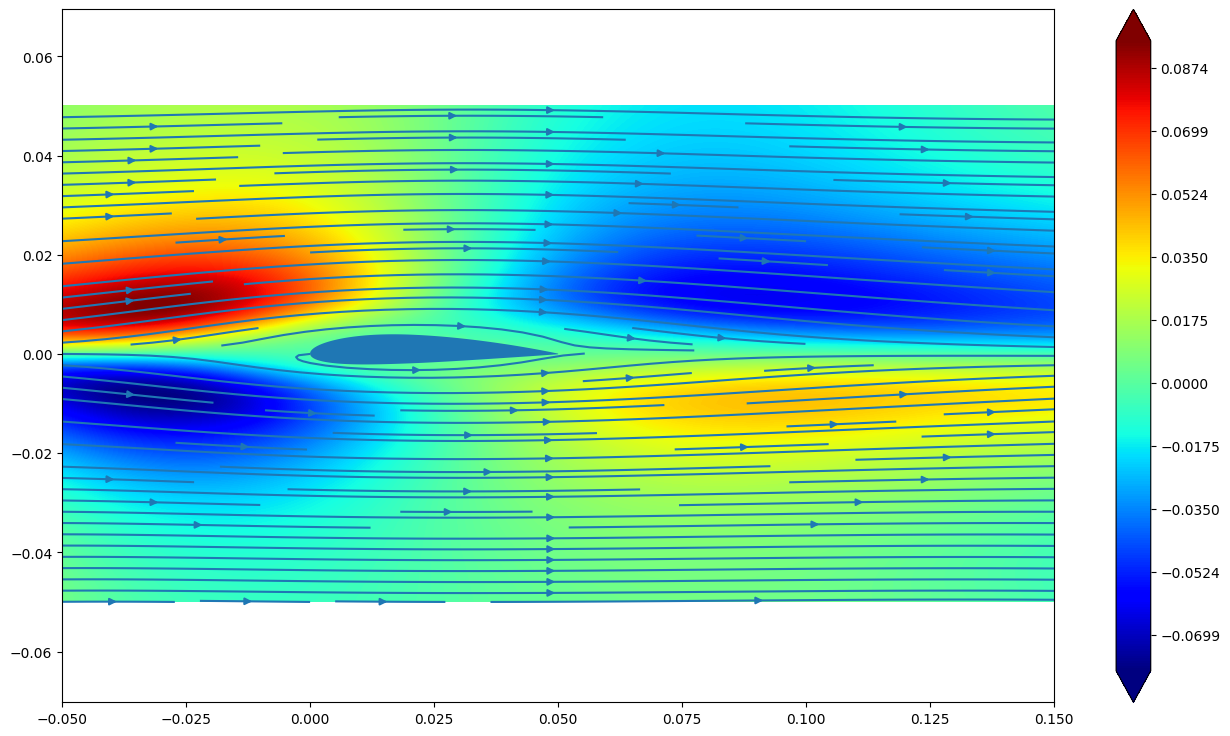

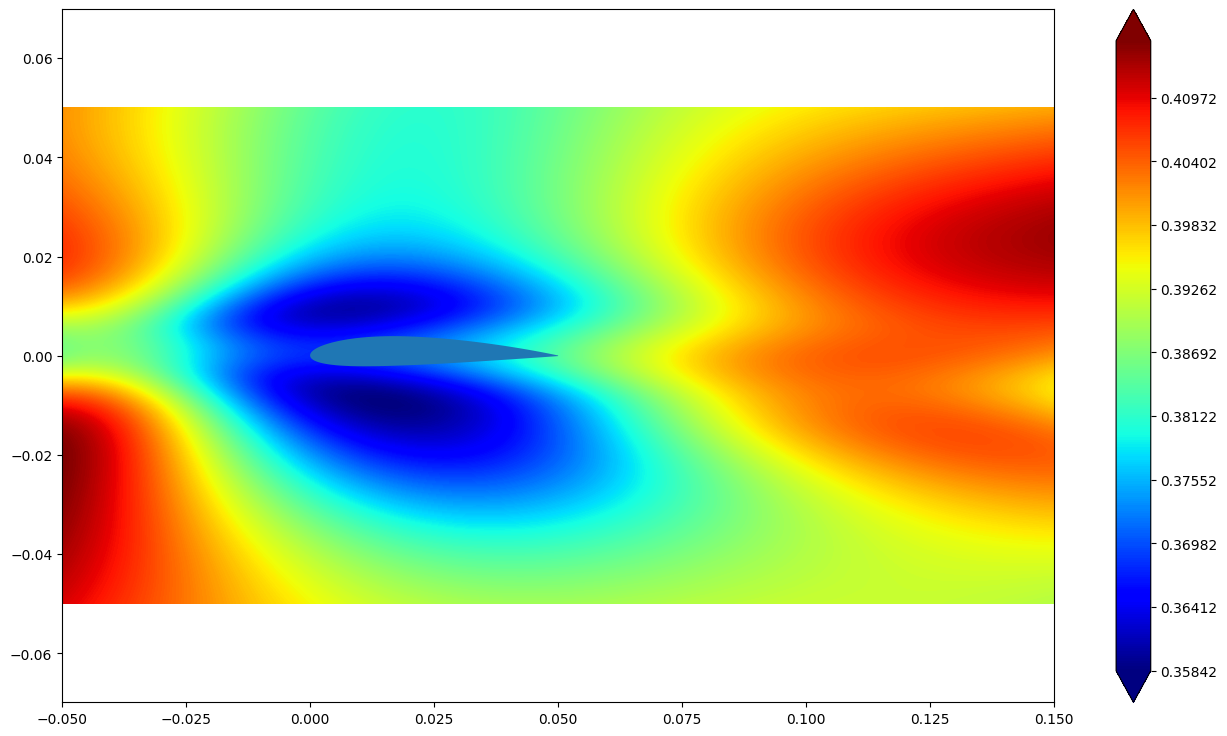

In [35]:
for i in range(len(X)):
   if airfoil_geom.inside(np.array([X[i]]))[0]:
       u[i] = 0.0
       v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

airfoil_plot = airfoil.get_boundary_points(150)

fig1, ax1 = plt.subplots(figsize = (16, 9))
ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(u.min(), u.max(), 0.001)
cnt1 = ax1.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig('./u.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
ax2.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(v.min(), v.max(), 0.00001)
cnt2 = ax2.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig('./v.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
clev = np.arange(p.min(), p.max(), 0.0001)
cnt3 = ax3.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig('./p.png')